## Massage Data Preprocessing Algorithm on Different Datasets 

### Dataset/Model Bias Check and Mitigation by Massage Data Preprocessing Algorithm

### Table of contents :
1. [Introduction](#1.-Introduction)
2. [Data preparation](#2.-Data-Preparation)
3. [Fairness Before Debiasing](#3.-Fairness-Before-Debiasing)
    * 3.1 [Bias In The Data](#3.1-Bias-In-The-Data)
    * 3.2 [Bias In The Model](#3.2-Bias-In-The-Model)
4. [Massage Data Preprocessing Algorithm](#4.-Massage-Data-Preprocessing-Algorithm)
5. [Fairness After Debiasing](#5.-Fairness-After-Debiasing)
    * 5.1 [Bias In The Data](#5.1-Bias-In-The-Data)
    * 5.2 [Bias In The Model](#5.2-Bias-In-The-Model)
6. [Fairness Comparission (Orignial vs Mitigated)](#6.-Fairness-Comparission-(Orignial-vs-Mitigated)) 
    * 6.1 [Data Fairness](#6.1-Data-Fairness)
    * 6.2 [Model Fairness](#6.2-Model-Performance-and-Fairness)
7. [Summary](#7.-Summary)
8. [References](#8.-References)

### 1. Introduction

Welcome!

The goal of this tutorial notebook is to demonstrate how to use the Massage Data Preprocessing algorithm to improve fairness metrics on different datasets. We have a separate tutorial notebook for the adult dataset where we have discussed each step of this algorithm in detail, So please [refer](https://github.com/sony/nnabla-examples/blob/master/interactive-demos/massage_adult_dataset.ipynb) to that notebook for more information. In this tutorial, we will dive into how to apply the algorithm on other datasets. Let's get started!

In [1]:
# Preparation
!git clone https://github.com/sony/nnabla-examples.git
%cd nnabla-examples/responsible_ai

In [2]:
import sys
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve, auc
sys.path.append('../responsible_ai/')
from massage_data.utils import *
from utils.data_loader import *

### 2. Data Preparation

First, let's load the dataset using the `load_data()` function, specifying the name of the dataset(`data_name`) and setting the `download` parameter. `download` is True if the dataset is not already available.
Then it uses the `train_test_split`function of the `data_loader` object to split the data into training and testing sets and shuffle (True) the data before the split.

The resulting datasets are assigned to the variables 'X_train', 'X_test','Y_train','Y_test','Z_train', and 'Z_test', which represent the features target variable and protected attributes for the training and testing data. These datasets can then be used to train models and also evaluate fairness.

In [3]:
data_loader = load_data(data_name='compas', download = True)
X_train, X_test,Y_train, Y_test, Z_train, Z_test = data_loader.train_test_split(test_size=0.3,shuffle=True)

To prepare the data for fairness evaluation, we need to define the target attribute, sensitive attribute, and privileged/unprivileged classes. We can use the 'data_loader' object created earlier to get this information.

In [4]:
target_attribute = data_loader.target_variable[0]
positive_class = data_loader.favorable_label
negative_class= data_loader.unfavorable_label
sensitive_attribute = data_loader.protected_attribute[0]
privileged_class= data_loader.privileged_classes[0]
unprivileged_class = data_loader.unprivileged_classes[0]

In [5]:
print(f"target_attribute : {target_attribute}")
print(f"positive_class : {positive_class}")
print(f"negative_class : {negative_class}")
print(f"sensitive_attribute : {sensitive_attribute}")
print(f"privileged_class : {privileged_class}")
print(f"unprivileged_class : {unprivileged_class}")

target_attribute : two_year_recid
positive_class : 1
negative_class : 0
sensitive_attribute : sex
privileged_class : 1
unprivileged_class : 0


### 3. Fairness Before Debiasing


#### 3.1 Bias In The Data

Now will check the data bias in the dataset using `Statistical Parity Difference` and `Disparate Impact` metrics before model training. For those who are unfamiliar with these metrics, please refer to our Gender Bias Mitigation and Four Metrics Tutorial Notebook for more information.

In [6]:
dpd_before_debiasing = statistical_parity_difference(X_train,Y_train,target_attribute,positive_class,sensitive_attribute,privileged_class,unprivileged_class)
di_before_debiasing = disparate_impact(X_train,Y_train,target_attribute,positive_class,sensitive_attribute,privileged_class,unprivileged_class)

In [7]:
print(f"Before Data debiasing : DPD {abs(dpd_before_debiasing)} Disparate Impact : {abs(di_before_debiasing)}" )

Before Data debiasing : DPD 0.12439645182650927 Disparate Impact : 0.807624817993205


#### 3.2 Bias In The Model

Here in this tutorial we have trained multiple classifiers to evaluate their performance and fairness before and after debiasing the dataset with the Massage Data Preprocessing Algorithm. To keep it simple and facilitate understanding, we have included only the Logistic Regression, GradientBoostingClassifier, Random Forest Classifier, and XGB Classifier in the models list. However, you can add your preferred models to the list and run the experiment accordingly.

In [8]:
models = []
models.append(('LR', LogisticRegression(max_iter=500,random_state=42)))
models.append(('GBC', GradientBoostingClassifier(random_state=42)))
models.append(('RF', RandomForestClassifier(random_state=42)))
models.append(('XGB', xgb.XGBClassifier(eval_metric='mlogloss',use_label_encoder=False)))

Let's standardize the dataset before training the model

In [9]:
scale_orig = StandardScaler()
S_train = scale_orig.fit_transform(X_train)
S_test = scale_orig.fit_transform(X_test)

As the next step, we will train all the models using the original dataset and evaluate their performance and fairness. We will compute the fairness metrics, including `Demographic Parity Difference (DPD)`, `Disparate Impact (DI)`, `Equal Opportunity Difference (EOD)`, and `Equalized Odds (AAOD)`, using the `get_model_fairness` function. Additionally, to evaluate the model performance, we will compute the `Accuracy` and `ROC-AUC` metrics.

In [10]:
models_names, dpd_list, di_list, eod_list, aaod_list, accuracy_list, roc_auc_list, preds_prob = [], [], [], [], [], [], [], []
for name, model in models:
    clf = train_model(model, S_train, Y_train.values.ravel())
    y_score = clf.predict_proba(S_test)[:, 1]
    preds = (y_score > 0.5).astype(int)
    accuracy = accuracy_score(Y_test, preds)
    fpr, tpr, _ = roc_curve(Y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    DPD, DI, EOD,AAOD = get_model_fairness(Y_test,Z_test[sensitive_attribute]==privileged_class,preds)
    dpd_list.append(abs(DPD))
    di_list.append(abs(DI))
    eod_list.append(abs(EOD))
    aaod_list.append(abs(AAOD))
    accuracy_list.append(accuracy)
    preds_prob.append(y_score)
    roc_auc_list.append(roc_auc)
    models_names.append(name)
    print(f"Model : {name} accuracy : {round(accuracy,2)} DPD : {abs(round(DPD,3))} ,DI : {abs(round(DI,3))}, EOD : {abs(round(EOD,3))} , AAOD : {abs(round(AAOD,3))}, AUC : {abs(round(roc_auc,3))}")

Model : LR accuracy : 0.66 DPD : 0.273 ,DI : 0.674, EOD : 0.197 , AAOD : 0.247, AUC : 0.654
Model : GBC accuracy : 0.68 DPD : 0.213 ,DI : 0.731, EOD : 0.153 , AAOD : 0.173, AUC : 0.673
Model : RF accuracy : 0.65 DPD : 0.211 ,DI : 0.703, EOD : 0.189 , AAOD : 0.167, AUC : 0.647
Model : XGB accuracy : 0.67 DPD : 0.174 ,DI : 0.767, EOD : 0.109 , AAOD : 0.14, AUC : 0.66


Check if the fairness metric indicates any bias towards a particular group. if such bias exists, use the Massage Data Preprocessing algorithm to address it and make the model more fair. 

To facilitate comparison of model performance and fairness, we will store all the relevant values in a dictionary

In [11]:
before_debiasing = defaultdict(dict)
before_debiasing["Accuracy"] = accuracy_list
before_debiasing["DPD"] = dpd_list
before_debiasing["DI"] = di_list
before_debiasing["EOD"] = eod_list
before_debiasing["AAOD"] = aaod_list
before_debiasing["AUC"] = roc_auc_list

### 4. Massage Data Preprocessing Algorithm

To learn more about the Massage Data Preprocessing Algorithm, we have created a tutorial notebook called ["massage_adult_dataset.ipynb"](https://github.com/sony/nnabla-examples/blob/master/interactive-demos/massage_adult_dataset.ipynb) where you can find the detailed explanation in section 4. Now let's define a function to obtain the promotion and demotion list.

In [12]:
def get_pr_dem(x_train,y_train,z_train,sensitive_attribute, sensitive_class,target_attribute,desired_class):
    # Create a ranker model to get promotion and demotion 
    ranker = RandomForestClassifier(random_state=42)
    # Fit the ranker model using the dataset D
    ranker.fit(x_train, y_train.values.ravel())
    pr = x_train[(z_train[sensitive_attribute] == sensitive_class) & (y_train[target_attribute] != desired_class)].copy()
    dem = x_train[(z_train[sensitive_attribute] != sensitive_class) & (y_train[target_attribute] == desired_class)].copy()
    pr["score"] = ranker.predict_proba(pr)[:,1]
    pr = pr.sort_values("score", ascending=False)
    dem["score"] = ranker.predict_proba(dem)[:,1]
    dem = dem.sort_values("score", ascending=True)
    return pr, dem

To achieve a discrimination-free dataset, we need to calculate the number of pairs of promotions and demotions that need to be modified. The formula to achieve zero discrimination is given below.

$disc_{S=b}(D) := \frac{\left|\{X \in D | X(S) = w, X(Class) = +\}\right|}{\left|\{X \in D | X(S) = w\}\right|} - \frac{\left|\{X \in D | X(S) = b, X(Class) = +\}\right|}{\left|\{X \in D | X(S) = b\}\right|}$,
$M = \text{disc}(D) \times \frac{|D_b| \times |D_w|}{|D|}$

In the above formula, the dataset is denoted by D, and S represents the sensitive attribute, b and w denotes the deprived and favored communities respectively and the superscript + represents the desired class.

In [13]:
def get_massaged_data(x_train,y_train,z_train, sensitive_attribute,sensitive_class,target_attribute,positive_class=1, negative_class=0):
    
    # Get the promotion and demotion lists
    pr, dem = get_pr_dem(x_train,y_train,z_train, sensitive_attribute, sensitive_class, target_attribute, positive_class)
    
    count_b_positive = len (x_train[(z_train[sensitive_attribute] == sensitive_class) & (y_train[target_attribute] == positive_class)])
    count_b = len(x_train[(z_train[sensitive_attribute] == sensitive_class)])
    
    count_w_positive = len(x_train[(z_train[sensitive_attribute] != sensitive_class) & (y_train[target_attribute] == positive_class)])
    count_w = len(x_train[(z_train[sensitive_attribute] != sensitive_class)])
    
    # Way to calculate M
    
    discS_b = abs((count_w_positive / count_w) - (count_b_positive / count_b))
    di = ((count_b_positive / count_b) / (count_w_positive / count_w))
    M = int((discS_b * count_w * count_b)/len(x_train))
    
    print ("Discrimination M(Relabeled) :",M)
    # change Top M objects of pr and dem
    pr = pr[:M]
    pr[target_attribute] = positive_class
    dem = dem[:M]
    dem[target_attribute] = negative_class
    
    y_train.loc[pr.index, target_attribute] = positive_class
    y_train.loc[dem.index, target_attribute] = negative_class

Now we have implemented the "Massage Data Preprocessing Algorithm", apply it on the specified dataset to reduce bias.

In [14]:
get_massaged_data(X_train,Y_train,Z_train, sensitive_attribute, unprivileged_class, target_attribute,positive_class)

Discrimination M(Relabeled) : 83


### 5. Fairness After Debiasing
#### 5.1 Bias In The Data

In [15]:
dpd_after_debiasing = statistical_parity_difference(X_train,Y_train,target_attribute,positive_class,sensitive_attribute,privileged_class,unprivileged_class)
di_after_debiasing = disparate_impact(X_train,Y_train,target_attribute,positive_class,sensitive_attribute,privileged_class,unprivileged_class)

In [16]:
print(f"After Data debiasing : DPD {abs(dpd_after_debiasing)} Disparate Impact : {abs(di_after_debiasing)}" )

After Data debiasing : DPD 0.0008204806312769319 Disparate Impact : 0.9984996925599507


#### 5.2 Bias In The Model
Let's train the model with the relabelled target attribute

In [17]:
models_names, dpd_list, di_list, eod_list, aaod_list, accuracy_list, roc_auc_list, preds_prob = [], [], [], [], [], [], [], []
for name, model in models:
    clf = train_model(model, S_train, Y_train.values.ravel())
    y_score = clf.predict_proba(S_test)[:, 1]
    preds = (y_score > 0.5).astype(int)
    accuracy = accuracy_score(Y_test, preds)
    fpr, tpr, _ = roc_curve(Y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    DPD, DI, EOD,AAOD = get_model_fairness(Y_test,Z_test[sensitive_attribute]==privileged_class,preds)
    dpd_list.append(abs(DPD))
    di_list.append(abs(DI))
    eod_list.append(abs(EOD))
    aaod_list.append(abs(AAOD))
    accuracy_list.append(accuracy)
    preds_prob.append(y_score)
    roc_auc_list.append(roc_auc)
    models_names.append(name)
    print(f"Model : {name} accuracy : {round(accuracy,2)} DPD : {abs(round(DPD,3))} ,DI : {abs(round(DI,3))}, EOD : {abs(round(EOD,3))} , AAOD : {abs(round(AAOD,3))}")

Model : LR accuracy : 0.66 DPD : 0.012 ,DI : 0.981, EOD : 0.009 , AAOD : 0.035
Model : GBC accuracy : 0.68 DPD : 0.087 ,DI : 0.872, EOD : 0.05 , AAOD : 0.038
Model : RF accuracy : 0.64 DPD : 0.118 ,DI : 0.81, EOD : 0.067 , AAOD : 0.085
Model : XGB accuracy : 0.66 DPD : 0.009 ,DI : 1.015, EOD : 0.063 , AAOD : 0.047


To facilitate comparison of model performance and fairness, we will store all the relevant values in a dictionary

In [18]:
after_debiasing = defaultdict(dict)
after_debiasing["Accuracy"] = accuracy_list
after_debiasing["DPD"] = dpd_list
after_debiasing["DI"] = di_list
after_debiasing["EOD"] = eod_list
after_debiasing["AAOD"] = aaod_list
after_debiasing["AUC"] = roc_auc_list

Now that we have all the data, let's plot and compare the bias of the original and modified datasets to determine if the fairness of the dataset and model has improved or not.

### 6. Fairness Comparission (Orignial vs Mitigated)

#### 6.1 Data Fairness

Compare the Statistical Parity Difference(Demogrpahic Parity) of Original and Relabelled dataset. 

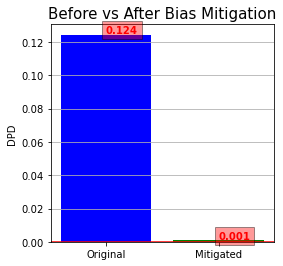

In [19]:
plot_fairness_comp(abs(dpd_before_debiasing),abs(dpd_after_debiasing))

compare the Disparate Impact of Original and Relabelled dataset.

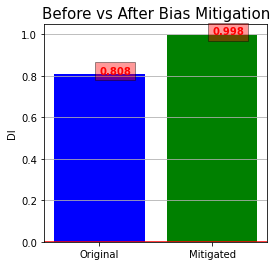

In [20]:
plot_fairness_comp(abs(di_before_debiasing),abs(di_after_debiasing),metric = "DI")

#### 6.2 Model Performance and Fairness

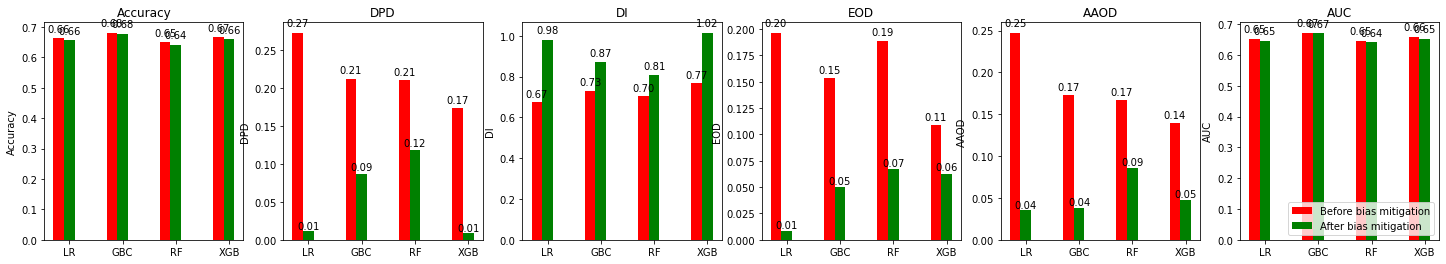

In [21]:
def autolabel(rects, axes):
        for rect in rects:
            h = rect.get_height()
            if h < 0:
                axes.text(rect.get_x() + rect.get_width() / 2., h - 0.04, '%.2f' % float(h),
                          ha='center', va='bottom')
            else:
                axes.text(rect.get_x() + rect.get_width() / 2., 1.02 * h, '%.2f' % float(h),
                          ha='center', va='bottom')
ind = np.arange(len(models_names))  # the x locations for the groups
width = 0.2  # the width of the bars

fig, axs = plt.subplots(1, 6, figsize=(25, 4))

for ax,metric in zip (axs.ravel(),after_debiasing.keys()):
    fairness_base_bar = ax.bar(ind, before_debiasing[metric], width, color='r',
                        label='Before bias mitigation')
    fairness_mitigated_bar = ax.bar(ind + width, after_debiasing[metric], width, color='g',
                                     label='After bias mitigation')
    ax.set_ylabel(metric)
    ax.set_xticks(ind + width)
    ax.set_xticklabels(models_names)
    ax.title.set_text(metric)
    autolabel(fairness_base_bar, axes=ax)
    autolabel(fairness_mitigated_bar, axes=ax)
plt.legend(loc ="lower right")
plt.show()

Above plots indicate whether there is any improvement in model fairness after application of "Massage Data Preprocessing Algorithm". We used several fairness metrics such as Demographic Parity, Disparate Impact, Equal Opportunity Difference and Equalised odds, along with Accuracy and ROC-AUC for measuring the model performance. However, in some cases, it can be observed that the model fairness decreases for some fairness metrics (Equal Opportunity Difference and Equalised odds) due to a large number of adjusted labels. If the number of adjusted labels are minimized, other fairness metrics could be improved.

### 7. Summary
This tutorial provides a high-level overview of how to use the "Massage Data Pre-processing" algorithm to reduce bias in datasets and mitigate discrimination in machine learning models. The algorithm operates on labeled datasets and adjusts the labels of sensitive attributes to achieve fairness. We demonstrated how to apply this algorithm on different datasets and showed how it can be used to improve fairness metrics.

### 8. References

1. Kamiran, Faisal, and Toon Calders. "Data preprocessing techniques for classification without discrimination." Knowledge and information systems 33, no. 1 (2012): 1-33.